<a href="https://colab.research.google.com/github/LimPark996/metal-defect-synthesis/blob/main/V0/metal_defect_synthesis(PoCFinal).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Wed Dec 10 06:16:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   35C    P0             60W /  400W |   23511MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir -p "/content/drive/MyDrive/metal-defect/checkpoints"
!mkdir -p "/content/drive/MyDrive/metal-defect/data"

In [ ]:
!git clone https://github.com/CompVis/taming-transformers.git

Cloning into 'taming-transformers'...
remote: Enumerating objects: 1342, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 1342 (delta 0), reused 0 (delta 0), pack-reused 1341 (from 2)
Receiving objects: 100% (1342/1342), 409.77 MiB | 14.38 MiB/s, done.
Resolving deltas: 100% (282/282), done.


In [ ]:
%cd taming-transformers

/content/taming-transformers


In [ ]:
!pip install -e .
!pip install omegaconf pytorch-lightning einops

Obtaining file:///content/taming-transformers
  Preparing metadata (setup.py) ... done
  Running setup.py develop for taming-transformers
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 32.5 MB/s eta 0:00:00


In [ ]:
try:
    # VQGAN 모델 코드를 불러와봄
    from taming.models.vqgan import VQModel
    print("✅ taming-transformers 설치 완료!")
except Exception as e:
    # 에러 발생시 메시지 출력
    print(f"❌ 설치 실패: {e}")

✅ taming-transformers 설치 완료!


In [ ]:
import os

In [ ]:
ckpt_dir = "/content/drive/MyDrive/metal-defect/checkpoints"

In [ ]:
os.makedirs(ckpt_dir, exist_ok=True)

In [ ]:
# 체크포인트: 모델의 학습된 가중치 (숫자 덩어리)
ckpt_path = f"{ckpt_dir}/vqgan_imagenet_f16_16384.ckpt"
# config: 모델 구조 설정 파일
config_path = f"{ckpt_dir}/model.yaml"

In [ ]:
# 체크포인트 다운로드
if not os.path.exists(ckpt_path):
    print("체크포인트 다운로드 중... (약 1.4GB, 5~10분 소요)")
    !wget -q --show-progress 'https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/files/?p=/ckpts/last.ckpt&dl=1' -O {ckpt_path}
else:
    print("체크포인트 이미 존재 (다운로드 스킵)")

# config 다운로드
if not os.path.exists(config_path):
    print("config 다운로드 중...")
    !wget -q 'https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/files/?p=/configs/model.yaml&dl=1' -O {config_path}
else:
    print("config 이미 존재 (다운로드 스킵)")

f8 체크포인트 다운로드 중... (약 700MB)
/content/drive/MyDr 100%[===================>] 791.82M  7.92MB/s    in 1m 42s  
f8 config 다운로드 중...


In [ ]:
!ls -lh {ckpt_dir}

total 22G
-rw------- 1 root root 2.1M Dec 10 06:08 comparison_before_after.png
-rw------- 1 root root  692 Dec  9 05:39 model.yaml
-rw------- 1 root root 209K Dec 10 05:51 training_curves.png
-rw------- 1 root root 938M Dec 10 05:12 vqgan_finetune_up_epoch10.pt
-rw------- 1 root root 938M Dec 10 05:17 vqgan_finetune_up_epoch15.pt
-rw------- 1 root root 938M Dec 10 05:22 vqgan_finetune_up_epoch20.pt
-rw------- 1 root root 938M Dec 10 05:27 vqgan_finetune_up_epoch25.pt
-rw------- 1 root root 938M Dec 10 05:32 vqgan_finetune_up_epoch30.pt
-rw------- 1 root root 938M Dec 10 05:36 vqgan_finetune_up_epoch35.pt
-rw------- 1 root root 938M Dec 10 05:41 vqgan_finetune_up_epoch40.pt
-rw------- 1 root root 938M Dec 10 05:46 vqgan_finetune_up_epoch45.pt
-rw------- 1 root root 938M Dec 10 05:51 vqgan_finetune_up_epoch50.pt
-rw------- 1 root root 933M Dec 10 05:07 vqgan_finetune_up_epoch5.pt
-rw------- 1 root root 935M Dec  9 05:33 vqgan_imagenet_f16_16384.ckpt
-rw------- 1 root root 792M Dec 10  20

In [ ]:
# Kaggle API 설치
!pip install kaggle

# Kaggle API 키 설정
# 1. kaggle.com → Settings → API → Create New Token → kaggle.json 다운로드
# 2. kaggle.json을 Google Drive에 업로드
# 3. 아래 경로 수정
!mkdir -p ~/.kaggle
!cp "/content/drive/MyDrive/kaggle.json" ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 데이터셋 다운로드
!kaggle datasets download -d kaustubhdikshit/neu-surface-defect-database

# 압축 해제
!unzip -q neu-surface-defect-database.zip -d /content/neu-det

# 경로 설정
neu_det_path = "/content/neu-det/NEU-DET"

Dataset URL: https://www.kaggle.com/datasets/kaustubhdikshit/neu-surface-defect-database
License(s): unknown
  0% 0.00/26.4M [00:00<?, ?B/s]
100% 26.4M/26.4M [00:00<00:00, 1.57GB/s]


In [ ]:
print(f"NEU-DET 경로: {neu_det_path}")
print("\n폴더 내용 확인:")
!ls -la {neu_det_path}

NEU-DET 경로: /content/neu-det/NEU-DET

폴더 내용 확인:
total 16
drwxr-xr-x 4 root root 4096 Dec 10 04:55 .
drwxr-xr-x 3 root root 4096 Dec 10 04:55 ..
drwxr-xr-x 4 root root 4096 Dec 10 04:55 train
drwxr-xr-x 4 root root 4096 Dec 10 04:55 validation


In [ ]:
import os

In [ ]:
from glob import glob

In [ ]:
neu_det_path = "/content/drive/MyDrive/metal-defect/data/NEU-DET"

In [ ]:
# 경로가 존재하는지 확인
if os.path.exists(neu_det_path):
    for folder in sorted(os.listdir(neu_det_path)):
        folder_path = os.path.join(neu_det_path, folder)
        if os.path.isdir(folder_path):
            # 폴더 안의 파일 개수 세기
            count = len(os.listdir(folder_path))
            print(f"  📁 {folder}: {count}장")
else:
    print(f"❌ 경로가 없습니다: {neu_det_path}")

# 전체 이미지 수 세기
all_images = glob(f"{neu_det_path}/**/*.jpg", recursive=True)

print(f"\n총 이미지 수: {len(all_images)}장")

# 결함 유형별 개수 확인
from collections import Counter
defect_types = [img.split('/')[-2] for img in all_images]
print("\n결함 유형별 개수:")
for defect, count in sorted(Counter(defect_types).items()):
    print(f"  - {defect}: {count}장")

  📁 train: 2장
  📁 validation: 2장

총 이미지 수: 1800장

결함 유형별 개수:
  - crazing: 300장
  - inclusion: 300장
  - patches: 300장
  - pitted_surface: 300장
  - rolled-in_scale: 300장
  - scratches: 300장


In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import random
import os

In [ ]:
# 한글 폰트 설치 및 설정
!apt-get install -y fonts-nanum > /dev/null 2>&1

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 폰트 직접 등록
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fm.fontManager.addfont(font_path)

# 나눔고딕 폰트 경로 찾기
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_prop = fm.FontProperties(fname=font_path)

# matplotlib 전역 설정
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

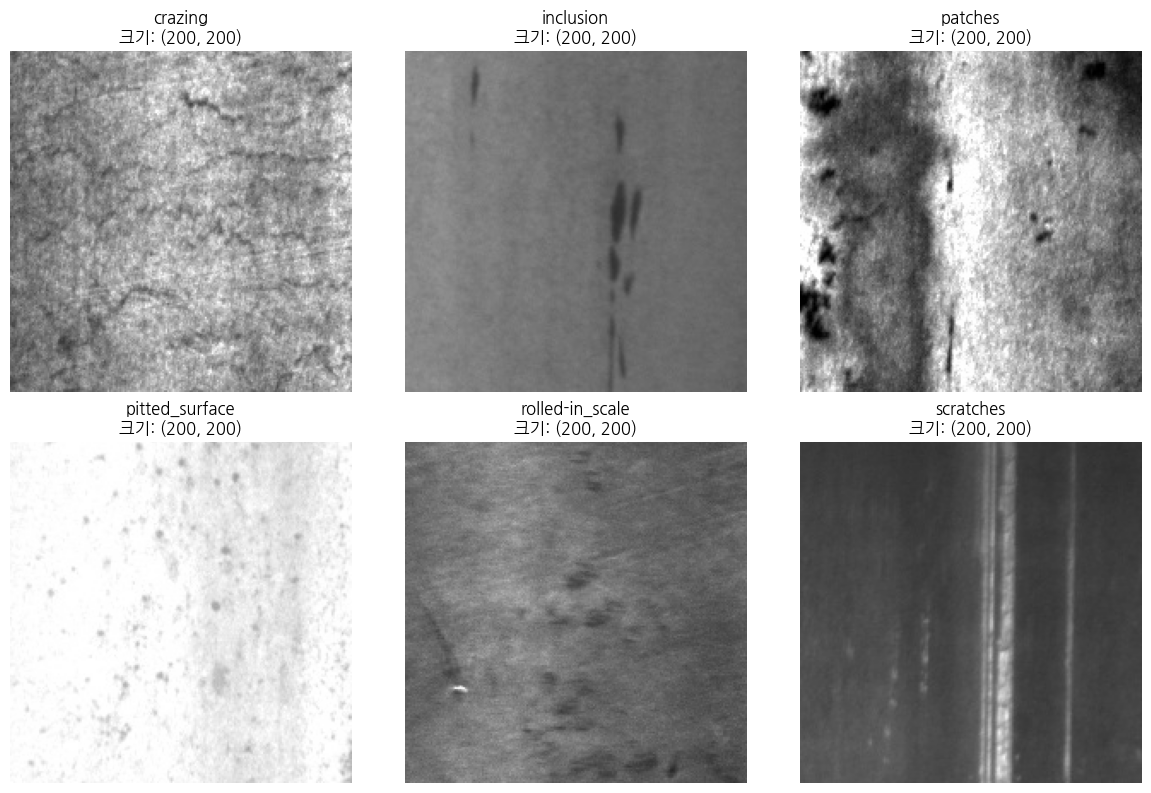

In [ ]:
classes = [
    'crazing',           # 크레이징 (미세 균열)
    'inclusion',         # 개재물 (이물질)
    'patches',           # 패치 (얼룩)
    'pitted_surface',    # 피팅 (점식)
    'rolled-in_scale',   # 압연 스케일
    'scratches'          # 스크래치 (긁힘)
]

fig, axes = plt.subplots(2, 3, figsize=(12, 8))

axes = axes.flatten()

# 각 클래스별로 샘플 이미지 1장씩 표시
for i, cls in enumerate(classes):
    # 클래스 폴더 경로
    cls_path = os.path.join(neu_det_path, "train", "images", cls)

    # 폴더가 있는지 확인
    if os.path.exists(cls_path):
        # 폴더 안의 이미지 목록
        images = os.listdir(cls_path)

        # 이미지가 있으면
        if images:
            # random.choice(): 리스트에서 무작위로 하나 선택
            img_name = random.choice(images)
            img_path = os.path.join(cls_path, img_name)

            # 이미지 열기
            img = Image.open(img_path)

            # 이미지 표시
            # cmap='gray': 흑백으로 표시
            axes[i].imshow(img, cmap='gray')
            # 제목: 클래스 이름과 이미지 크기
            axes[i].set_title(f"{cls}\n크기: {img.size}")
            # 축 눈금 숨기기
            axes[i].axis('off')
    else:
        print(f"⚠️ 폴더 없음: {cls}")

# 그래프 레이아웃 자동 조정
plt.tight_layout()

In [ ]:
import torch
import torchvision.transforms as T
from PIL import Image
import numpy as np

-----------------------------------------------------------------------------
전처리 파이프라인 설명:

NEU-DET 이미지: 200x200 픽셀, 흑백(1채널)

VQGAN 입력: 256x256 픽셀, 컬러(3채널), 값 범위 [-1, 1]

그래서 다음 변환이 필요:
1. 200x200 → 256x256 크기 변경
2. 흑백 → RGB (채널 3개로 복제)
3. 픽셀값 [0, 255] → [0, 1] → [-1, 1]
-----------------------------------------------------------------------------


In [ ]:
# T.Compose: 여러 변환을 순서대로 적용
transform = T.Compose([
    # 1단계: 크기 변경
    # 200x200 → 256x256
    T.Resize((256, 256)),

    # 2단계: 흑백 → RGB
    # num_output_channels=3: 같은 값을 3번 복제
    T.Grayscale(num_output_channels=3),

    # 3단계: PIL 이미지 → PyTorch 텐서
    # [0, 255] 정수 → [0, 1] 실수로 변환됨
    T.ToTensor(),

    # 4단계: 정규화
    # [0, 1] → [-1, 1] 범위로 변환
    # 공식: (값 - 0.5) / 0.5
    T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [ ]:
def denormalize(tensor):
    """
    텐서를 다시 이미지로 바꾸기 위한 역변환 함수
    [-1, 1] → [0, 1] → numpy 배열

    Args:
        tensor: 정규화된 PyTorch 텐서

    Returns:
        numpy 배열 (이미지로 표시 가능)
    """
    # 원본 텐서를 수정하지 않도록 복사본 생성
    tensor = tensor.clone()

    # [-1, 1] → [0, 1]
    # 공식: 값 * 0.5 + 0.5
    tensor = tensor * 0.5 + 0.5

    # 값을 0~1 범위로 제한 (혹시 모를 오류 방지)
    tensor = tensor.clamp(0, 1)

    # 배치 차원이 있으면 제거
    # [1, 3, 256, 256] → [3, 256, 256]
    if tensor.dim() == 4:
        tensor = tensor[0]

    # PyTorch: [채널, 높이, 너비] → numpy: [높이, 너비, 채널]
    # matplotlib은 [높이, 너비, 채널] 형태를 기대함
    return tensor.permute(1, 2, 0).cpu().numpy()

In [ ]:
# 테스트용 이미지 경로 찾기
test_image_paths = os.path.join(neu_det_path, "train", "images", "crazing")

# 폴더 안의 이미지 목록
images = os.listdir(test_image_paths)

if images:
    # 첫 번째 이미지로 테스트
    sample_path = os.path.join(test_image_paths,images[0])

    # 이미지 열기
    sample_img = Image.open(sample_path)

    # 전처리 적용
    # unsqueeze(0): 배치 차원 추가 [3, 256, 256] → [1, 3, 256, 256]
    sample_tensor = transform(sample_img).unsqueeze(0)

    # 결과 확인
    print("=== 전처리 테스트 ===")
    print(f"원본 이미지: {sample_img.size}, 모드={sample_img.mode}")
    print(f"변환 후 텐서: {sample_tensor.shape}")
    print(f"값 범위: [{sample_tensor.min():.2f}, {sample_tensor.max():.2f}]")
    print("\n✅ 전처리 함수 준비 완료!")
else:
    print("❌ 테스트할 이미지가 없습니다. 경로를 확인하세요.")

=== 전처리 테스트 ===
원본 이미지: (200, 200), 모드=RGB
변환 후 텐서: torch.Size([1, 3, 256, 256])
값 범위: [-0.52, 1.00]

✅ 전처리 함수 준비 완료!


In [ ]:
import torch
from omegaconf import OmegaConf
import sys
sys.path.append('/content/taming-transformers')
from taming.models.vqgan import VQModel

In [ ]:
# 체크포인트 폴더
ckpt_dir = "/content/drive/MyDrive/metal-defect/checkpoints"

# 설정 파일 경로 (모델 구조 정보)
config_path = f"{ckpt_dir}/model.yaml"

# 체크포인트 경로 (학습된 가중치)
ckpt_path = f"{ckpt_dir}/vqgan_imagenet_f16_16384.ckpt"

In [ ]:
# 1. 설정 파일 로드
# OmegaConf.load(): YAML 파일을 딕셔너리처럼 읽음
config = OmegaConf.load(config_path)

print("=== VQGAN 설정 ===")
print(f"임베딩 차원: {config.model.params.embed_dim}")
print(f"코드북 크기: {config.model.params.n_embed}")

=== VQGAN 설정 ===
임베딩 차원: 256
코드북 크기: 16384


In [ ]:
# 2. 모델 인스턴스 생성
# **config.model.params: 딕셔너리를 키워드 인자로 풀어서 전달
model = VQModel(**config.model.params)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:02<00:00, 197MB/s]


8.19kB [00:00, 516kB/s]                    

loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


In [ ]:
# 3. 체크포인트(가중치) 로드
# map_location="cuda": GPU 메모리에 로드
ckpt = torch.load(ckpt_path, map_location="cuda",weights_only=False)

In [ ]:
# 체크포인트 구조에 따라 가중치 추출
if "state_dict" in ckpt:
    state_dict = ckpt["state_dict"]
else:
    state_dict = ckpt

In [ ]:
# 4. 가중치를 모델에 적용
# strict=False: 일부 키가 안 맞아도 무시 (호환성)
model.load_state_dict(state_dict, strict=False)

<All keys matched successfully>

In [ ]:
# 5. GPU로 이동 + 평가 모드
# torch.device(): 연산할 장치 지정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# .to(device): 모델을 해당 장치로 이동
model = model.to(device)
# .eval(): 평가 모드 (학습 시 쓰는 Dropout 등 비활성화)
model.eval()

VQModel(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down): ModuleList(
      (0-1): 2 x Module(
        (block): ModuleList(
          (0-1): 2 x ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
        (attn): ModuleList()
        (downsample): Downsample(
          (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
        )
      )
      (2): Module(
        (block): ModuleList(
          (0): ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (no

In [ ]:
# 파라미터 수 계산
# p.numel(): 각 파라미터의 원소 개수
total_params = sum(p.numel() for p in model.parameters())

In [ ]:
print(f"\n✅ VQGAN 모델 로드 완료!")
print(f"장치: {device}")
print(f"파라미터 수: {total_params:,}개")


✅ VQGAN 모델 로드 완료!
장치: cuda
파라미터 수: 91,453,380개


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# 테스트용 이미지 경로 찾기
test_image_paths = os.path.join(neu_det_path, "train", "images", "scratches")
images = os.listdir(test_image_paths)
test_path = os.path.join(test_image_paths,images[0])

test_img = Image.open(test_path)

In [ ]:
# 전처리: PIL 이미지 → 텐서
# .unsqueeze(0): 배치 차원 추가 [3,256,256] → [1,3,256,256]
# .to(device): GPU로 이동
x = transform(test_img).unsqueeze(0).to(device)

print(f"입력 텐서 shape: {x.shape}")

입력 텐서 shape: torch.Size([1, 3, 256, 256])


-----------------------------------------------------------------------------
인코딩 → 디코딩
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------

In [ ]:
# torch.no_grad(): 기울기 계산 안 함 (추론할 때 메모리 절약)
with torch.no_grad():
    # 1. 인코딩: 이미지 → 잠재 벡터 (latent)
    # model.encode()는 (z, emb_loss, info) 튜플 반환
    z, _, _ = model.encode(x)
    print(f"Latent shape: {z.shape}")  # [1, 256, 16, 16] 예상

    # 2. 양자화: 연속적인 latent → 이산적인 코드북 인덱스
    # 코드북: 16384개의 패턴 사전
    z_q, _, _ = model.quantize(z)
    print(f"Quantized shape: {z_q.shape}")

    # 3. 디코딩: 양자화된 latent → 이미지
    x_rec = model.decode(z_q)
    print(f"재구성 이미지 shape: {x_rec.shape}")

Latent shape: torch.Size([1, 256, 16, 16])
Quantized shape: torch.Size([1, 256, 16, 16])
재구성 이미지 shape: torch.Size([1, 3, 256, 256])


-----------------------------------------------------------------------------
시각화
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------

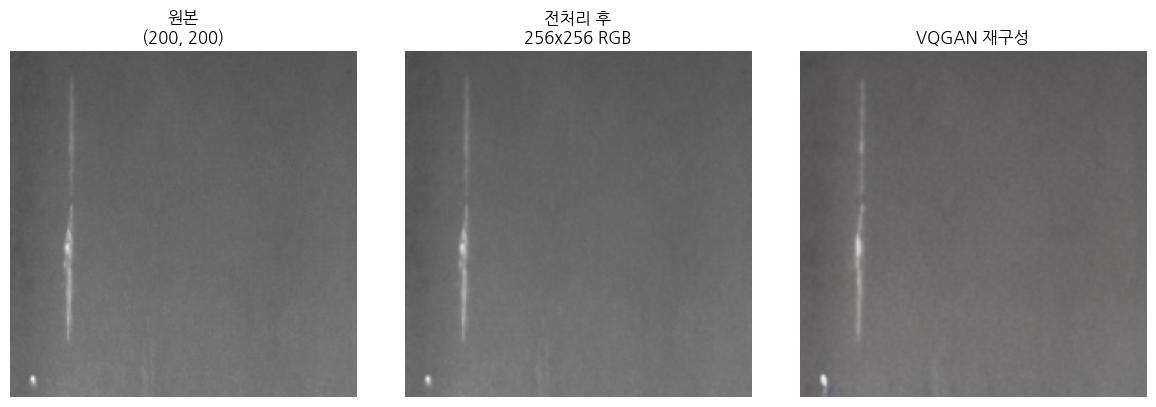

In [ ]:
# 1행 3열 그래프
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# 원본 이미지 (PIL)
axes[0].imshow(test_img, cmap='gray')
axes[0].set_title(f"원본\n{test_img.size}")
axes[0].axis('off')

# 전처리된 이미지 (텐서 → numpy)
axes[1].imshow(denormalize(x))
axes[1].set_title(f"전처리 후\n256x256 RGB")
axes[1].axis('off')

# 재구성 이미지
axes[2].imshow(denormalize(x_rec))
axes[2].set_title("VQGAN 재구성")
axes[2].axis('off')

plt.tight_layout()

In [ ]:
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# 텐서 → numpy 변환 (0~1 범위)
img_original = denormalize(x)  # 전처리된 이미지
img_reconstructed = denormalize(x_rec)  # 재구성 이미지

# numpy array로 변환
if not isinstance(img_original, np.ndarray):
    img_original = np.array(img_original)
    img_reconstructed = np.array(img_reconstructed)

# 1. MSE (Mean Squared Error) - 낮을수록 좋음
mse = np.mean((img_original - img_reconstructed) ** 2)

# 2. PSNR (Peak Signal-to-Noise Ratio) - 높을수록 좋음 (보통 30+ 좋음)
psnr_value = psnr(img_original, img_reconstructed, data_range=1.0)

# 3. SSIM (Structural Similarity) - 1에 가까울수록 좋음
ssim_value = ssim(img_original, img_reconstructed, channel_axis=2, data_range=1.0)

print("=== 이미지 품질 비교 ===")
print(f"MSE:  {mse:.6f}  (낮을수록 좋음)")
print(f"PSNR: {psnr_value:.2f} dB  (30+ 좋음, 40+ 매우좋음)")
print(f"SSIM: {ssim_value:.4f}  (1에 가까울수록 좋음)")

=== 이미지 품질 비교 ===
MSE:  0.000153  (낮을수록 좋음)
PSNR: 38.16 dB  (30+ 좋음, 40+ 매우좋음)
SSIM: 0.9340  (1에 가까울수록 좋음)


=============================================================================
PyTorch Dataset 클래스 정의 (Fine-tuning용)
=============================================================================
=============================================================================

In [ ]:
# Dataset: 데이터를 불러오는 방법을 정의
# DataLoader: 배치 단위로 데이터를 공급
from torch.utils.data import Dataset, DataLoader

class NEUDataset(Dataset):
    """
    NEU-DET 데이터셋을 PyTorch가 이해하는 형태로 감싸는 클래스

    Dataset을 상속받으면 __len__과 __getitem__을 구현해야 함
    """

    def __init__(self, root_dir, split="train", transform=None):
        """
        초기화 함수 (객체 생성 시 호출)

        Args:
            root_dir: NEU-DET 폴더 경로
            split: "train" 또는 "validation"
            transform: 이미지 전처리 함수
        """
        # 이미지 경로 저장할 리스트
        self.image_paths = []
        # 라벨(클래스 번호) 저장할 리스트
        self.labels = []
        # 클래스 이름 저장할 리스트
        self.class_names = []

        # 실제 이미지 폴더 경로 구성
        images_dir = os.path.join(root_dir, split, "images")

        if not os.path.exists(images_dir):
            raise ValueError(f"경로가 없습니다: {images_dir}")

        # root_dir 안의 모든 폴더 탐색
        # sorted(): 알파벳 순 정렬 (일관된 순서 보장)
        # enumerate(): 인덱스와 값을 동시에 반환
        for class_idx, class_name in enumerate(sorted(os.listdir(images_dir))):
            # 전체 경로 만들기
            class_dir = os.path.join(images_dir, class_name)

            # 폴더인지 확인 (파일 제외)
            if os.path.isdir(class_dir):
                # 클래스 이름 저장
                self.class_names.append(class_name)

                # 해당 폴더의 모든 이미지 파일
                for img_name in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img_name)
                    # 경로와 라벨 저장
                    self.image_paths.append(img_path)
                    self.labels.append(class_idx)

        # 전처리 함수 저장
        # transform이 None이면 기본 전처리 사용
        if transform is None:
            self.transform = T.Compose([
                T.Resize((256, 256)),
                T.Grayscale(num_output_channels=3),
                T.ToTensor(),
                T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
            ])
        else:
            self.transform = transform

        # 데이터셋 정보 출력
        print(f"클래스: {self.class_names}")
        print(f"총 이미지: {len(self.image_paths)}장")

    def __len__(self):
        """
        데이터셋 크기 반환 (len(dataset)하면 호출됨)
        """
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        인덱스로 데이터 하나 가져오기 (dataset[0]하면 호출됨)

        Args:
            idx: 가져올 데이터의 인덱스

        Returns:
            (이미지 텐서, 라벨) 튜플
        """
        # 이미지 열기
        img = Image.open(self.image_paths[idx])

        # 전처리 적용
        img = self.transform(img)

        # 라벨
        label = self.labels[idx]

        return img, label

 -----------------------------------------------------------------------------
데이터셋 & 데이터로더 생성
 -----------------------------------------------------------------------------
 -----------------------------------------------------------------------------


In [ ]:
# train 데이터셋
dataset = NEUDataset(root_dir=neu_det_path, split="train")

클래스: ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']
총 이미지: 1440장


In [ ]:
# 배치 사이즈: 한 번에 처리할 이미지 수
# GPU 메모리에 따라 조절 (8~16 권장)
# 메모리 에러 나면 줄이기
batch_size = 8

# DataLoader: 데이터를 배치 단위로 공급
# shuffle=True: 매 에폭마다 순서 섞기
# num_workers=2: 데이터 로딩에 2개 프로세스 사용
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

# 테스트: 첫 번째 배치 가져오기
# next(iter()): 반복자에서 첫 번째 요소 가져오기
test_batch, test_labels = next(iter(dataloader))

print(f"\n배치 shape: {test_batch.shape}")  # [8, 3, 256, 256]
print(f"라벨: {test_labels}")


배치 shape: torch.Size([8, 3, 256, 256])
라벨: tensor([4, 3, 4, 2, 0, 3, 3, 2])


=============================================================================
Fine-tuning 설정
=============================================================================
=============================================================================

In [ ]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# -----------------------------------------------------------------------------
# 하이퍼파라미터 설정
# -----------------------------------------------------------------------------

# Learning Rate (학습률)
# 너무 크면: 학습이 불안정, 기존 지식 손실
# 너무 작으면: 학습이 너무 느림
# 사전학습 모델 fine-tuning 시에는 작은 값 사용!
learning_rate = 1e-5  # 0.00001

# 에폭 수: 전체 데이터를 몇 번 반복할지
# NEU-DET 1800장, 배치 8개 → 1 에폭 = 225 스텝
# 30 에폭 = 약 6,750 스텝
num_epochs = 30

# 몇 에폭마다 모델 저장할지
save_every = 1

In [ ]:
model.train()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

mse_loss = nn.MSELoss()

# 저장 경로
save_dir = "/content/drive/MyDrive/metal-defect/checkpoints"
os.makedirs(save_dir, exist_ok=True)

# 설정 확인
print("=== Fine-tuning 설정 ===")
print(f"Learning Rate: {learning_rate}")
print(f"Epochs: {num_epochs}")
print(f"Batch Size: {batch_size}")
print(f"총 스텝 수: 약 {num_epochs * len(dataloader):,}")
print(f"저장 경로: {save_dir}")

=== Fine-tuning 설정 ===
Learning Rate: 1e-05
Epochs: 30
Batch Size: 8
총 스텝 수: 약 5,400
저장 경로: /content/drive/MyDrive/metal-defect/checkpoints


=============================================================================
Fine-tuning 수행
=============================================================================
=============================================================================

In [ ]:
 # =============================================================================
# VQGAN Fine-tuning (원본 taming-transformers 소스 코드 기준)
# =============================================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

# taming-transformers 모듈 불러오기
import sys
sys.path.append('/content/taming-transformers')

from omegaconf import OmegaConf
from taming.models.vqgan import VQModel
from taming.modules.discriminator.model import NLayerDiscriminator, weights_init
from taming.modules.losses.lpips import LPIPS

# =============================================================================
# 1. adopt_weight 함수
# =============================================================================
# global_step이 threshold보다 작으면 weight를 value(기본값 0)로 설정합니다.
# 즉, 학습 초반에는 GAN loss를 0으로 만들어서 reconstruction만 학습하고,
# threshold 스텝 이후부터 GAN loss를 활성화합니다.

def adopt_weight(weight, global_step, threshold=0, value=0.):
    if global_step < threshold:
        weight = value
    return weight


# =============================================================================
# 2. Hinge Loss 함수들
# =============================================================================
# Discriminator용과 Generator용이 따로 있는 게 아니라,
# Discriminator loss만 함수로 정의하고, Generator loss는 forward에서 직접 계산합니다.

def hinge_d_loss(logits_real, logits_fake):
    """
    Discriminator용 Hinge Loss
    - logits_real: 진짜 이미지에 대한 discriminator 출력
    - logits_fake: 가짜(재구성) 이미지에 대한 discriminator 출력

    진짜는 1보다 크게, 가짜는 -1보다 작게 만들려고 합니다.
    relu(1 - real): real이 1보다 크면 0, 작으면 페널티
    relu(1 + fake): fake가 -1보다 작으면 0, 크면 페널티
    """
    loss_real = torch.mean(F.relu(1. - logits_real))
    loss_fake = torch.mean(F.relu(1. + logits_fake))
    d_loss = 0.5 * (loss_real + loss_fake)
    return d_loss


# =============================================================================
# 3. Adaptive Weight 계산 함수
# =============================================================================
# 이 함수가 코드의 핵심입니다.
# reconstruction loss와 GAN loss의 gradient 크기를 비교해서
# 두 loss가 비슷한 영향력을 갖도록 가중치를 자동 조절합니다.

def calculate_adaptive_weight(nll_loss, g_loss, last_layer, disc_weight=1.0):
    """
    Adaptive weight 계산

    Parameters:
    - nll_loss: reconstruction loss (L1 + perceptual)
    - g_loss: generator의 GAN loss
    - last_layer: decoder의 마지막 레이어 weight (gradient 계산 기준점)
    - disc_weight: 기본 discriminator weight (config에서 설정, 보통 0.8)

    Returns:
    - d_weight: GAN loss에 곱해줄 adaptive weight
    """
    # 각 loss가 last_layer에 미치는 gradient를 계산합니다.
    # retain_graph=True: 이후에도 backward를 또 할 수 있도록 그래프를 유지합니다.
    nll_grads = torch.autograd.grad(nll_loss, last_layer, retain_graph=True)[0]
    g_grads = torch.autograd.grad(g_loss, last_layer, retain_graph=True)[0]

    # gradient의 L2 norm(크기)을 계산해서 비율을 구합니다.
    # nll_grads가 크고 g_grads가 작으면 d_weight가 커져서 GAN loss 영향력 증가
    # nll_grads가 작고 g_grads가 크면 d_weight가 작아져서 GAN loss 영향력 감소
    # 1e-4는 division by zero 방지용 epsilon입니다.
    d_weight = torch.norm(nll_grads) / (torch.norm(g_grads) + 1e-4)

    # 극단적인 값 방지: 0 ~ 10000 사이로 clamp
    d_weight = torch.clamp(d_weight, 0.0, 1e4).detach()

    # config에서 설정한 disc_weight를 곱해줍니다.
    d_weight = d_weight * disc_weight

    return d_weight


# =============================================================================
# 4. 모델 및 컴포넌트 로드
# =============================================================================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ckpt_dir = "/content/drive/MyDrive/metal-defect/checkpoints"

# 경로 설정
config_path = f"{ckpt_dir}/model.yaml"  # config 파일 경로
ckpt_path = f"{ckpt_dir}/vqgan_imagenet_f16_16384.ckpt"    # checkpoint 파일 경로
save_dir = f"{ckpt_dir}"                       # 저장 디렉토리

# Config 로드 및 VQModel 생성
config = OmegaConf.load(config_path)
model = VQModel(**config.model.params)

# 전체 체크포인트 로드
ckpt = torch.load(ckpt_path, map_location="cuda", weights_only=False)
full_state_dict = ckpt["state_dict"]

# VQModel 부분만 추출해서 로드 (loss. 로 시작하는 키 제외)
vqmodel_state_dict = {k: v for k, v in full_state_dict.items()
                      if not k.startswith("loss.")}
model.load_state_dict(vqmodel_state_dict, strict=False)
model = model.to(device)
print("✅ VQModel 로드 완료")

# -----------------------------------------------------------------------------
# Discriminator 로드
# -----------------------------------------------------------------------------
discriminator = NLayerDiscriminator(
    input_nc=3,      # RGB 입력
    n_layers=2,      # 레이어 수 (원본 config 기준)
    ndf=64           # 기본 필터 수
).apply(weights_init)  # 원본처럼 weight 초기화 적용

# 체크포인트에서 Discriminator 가중치 추출
disc_state_dict = {}
for k, v in full_state_dict.items():
    if k.startswith("loss.discriminator."):
        new_key = k.replace("loss.discriminator.", "")
        disc_state_dict[new_key] = v

if disc_state_dict:
    discriminator.load_state_dict(disc_state_dict, strict=False)
    print(f"✅ Discriminator 로드 완료 (키 {len(disc_state_dict)}개)")
else:
    print("⚠️ Discriminator 가중치 없음, weights_init으로 초기화됨")

discriminator = discriminator.to(device)

# -----------------------------------------------------------------------------
# Perceptual Loss (LPIPS) 로드
# -----------------------------------------------------------------------------
perceptual_loss = LPIPS().eval()
perceptual_loss = perceptual_loss.to(device)

# LPIPS는 고정 (학습하지 않음)
for param in perceptual_loss.parameters():
    param.requires_grad = False

print("✅ Perceptual Loss (LPIPS) 로드 완료")


# =============================================================================
# 5. 하이퍼파라미터 설정 (원본 config 기준)
# =============================================================================

# 학습 설정
num_epochs = 50
save_every = 5

# Loss 가중치들 (원본 config 기준)
codebook_weight = 1.0       # codebook loss 가중치
pixel_weight = 1.0          # L1 reconstruction loss 가중치
perceptual_weight = 1.0     # perceptual loss 가중치
disc_weight = 0.8           # discriminator weight (adaptive weight 계산에 사용)
disc_factor = 1.0           # GAN loss 전체에 곱해지는 factor

# Discriminator 시작 스텝
# 원본 config들 보면 10000 ~ 250001까지 다양함
# fine-tuning이니까 좀 더 빠르게 시작해도 됨
disc_start = 1000

print(f"\n=== 하이퍼파라미터 ===")
print(f"Learning Rate: {learning_rate}")
print(f"Codebook Weight: {codebook_weight}")
print(f"Perceptual Weight: {perceptual_weight}")
print(f"Disc Weight: {disc_weight}")
print(f"Disc Start: {disc_start} steps")


# =============================================================================
# 6. Optimizer 설정
# =============================================================================

# 학습 파라미터 수 확인
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"\n학습 파라미터: {trainable_params:,} / {total_params:,} ({100*trainable_params/total_params:.1f}%)")

# Generator (VQModel) optimizer
# 원본은 Adam with betas=(0.5, 0.9)
optimizer_g = optim.Adam([
    {'params': model.encoder.parameters(), 'lr': 1e-7},
    {'params': model.quant_conv.parameters(), 'lr': 1e-7},
    {'params': model.quantize.parameters(), 'lr': 4.5e-6},
    {'params': model.post_quant_conv.parameters(), 'lr': 4.5e-6},
    {'params': model.decoder.parameters(), 'lr': 4.5e-6},
], betas=(0.5, 0.9))

# Discriminator optimizer
optimizer_d = optim.Adam(
    discriminator.parameters(),
    lr=4.5e-6,
    betas=(0.5, 0.9)
)


# =============================================================================
# 7. Fine-tuning 메인 루프
# =============================================================================

# 학습 기록용
train_logs = []
global_step = 0

print("\n" + "=" * 70)
print("VQGAN Fine-tuning 시작 (원본 taming-transformers 구조)")
print("=" * 70 + "\n")

for epoch in range(num_epochs):
    model.train()
    discriminator.train()

    epoch_logs = {
        'total_loss': 0, 'nll_loss': 0, 'codebook_loss': 0,
        'g_loss': 0, 'd_loss': 0, 'd_weight': 0
    }

    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for batch_idx, (images, _) in enumerate(pbar):
        images = images.to(device)
        global_step += 1

        # =================================================================
        # Forward Pass: Encode -> Quantize -> Decode
        # =================================================================

        # encode: 이미지를 latent space로 인코딩
        z = model.encoder(images)
        z = model.quant_conv(z)

        # quantize: latent를 codebook의 가장 가까운 벡터로 양자화
        # 반환값: (양자화된 z, loss, (perplexity, min_encodings, min_encoding_indices))
        # 여기서 두 번째 반환값이 codebook_loss입니다!
        z_q, codebook_loss, _ = model.quantize(z)

        # decode: 양자화된 latent를 이미지로 복원
        z_q = model.post_quant_conv(z_q)
        reconstructions = model.decoder(z_q)

        # =================================================================
        # Generator (VQModel) 업데이트 - optimizer_idx = 0
        # =================================================================

        # ----- nll_loss 계산 (L1 + Perceptual) -----
        # 원본 코드: rec_loss = L1 + perceptual_weight * p_loss
        # 그 다음 nll_loss = mean(rec_loss)

        # L1 reconstruction loss (픽셀 단위 절대값 차이)
        rec_loss = torch.abs(images.contiguous() - reconstructions.contiguous())

        # Perceptual loss 추가
        if perceptual_weight > 0:
            p_loss = perceptual_loss(images.contiguous(), reconstructions.contiguous())
            rec_loss = rec_loss + perceptual_weight * p_loss
        else:
            p_loss = torch.tensor([0.0]).to(device)

        # 평균 내서 nll_loss 완성
        nll_loss = torch.mean(rec_loss)

        # ----- GAN loss (Generator 입장) -----
        # Generator는 Discriminator를 속이고 싶음
        # Discriminator가 fake를 real로 판단하면 logits_fake가 높아짐
        # Generator loss = -mean(logits_fake): fake의 점수가 높을수록 loss 감소

        logits_fake = discriminator(reconstructions.contiguous())
        g_loss = -torch.mean(logits_fake)

        # ----- Adaptive Weight 계산 -----
        # disc_start 이전에는 d_weight 계산을 건너뜁니다.
        # 왜냐하면 아직 GAN loss를 쓰지 않을 거니까요.

        # disc_factor: disc_start 이전이면 0, 이후면 원래 값
        current_disc_factor = adopt_weight(disc_factor, global_step, threshold=disc_start)

        if current_disc_factor > 0:
            # Adaptive weight 계산
            # last_layer: decoder의 마지막 conv layer의 weight
            # 이 레이어 기준으로 각 loss의 gradient 크기를 비교합니다.
            try:
                d_weight = calculate_adaptive_weight(
                    nll_loss, g_loss,
                    last_layer=model.decoder.conv_out.weight,
                    disc_weight=disc_weight
                )
            except RuntimeError:
                # validation 등에서 gradient 계산 불가능한 경우
                d_weight = torch.tensor(0.0).to(device)
        else:
            d_weight = torch.tensor(0.0).to(device)

        # ----- Total Generator Loss -----
        # 원본 공식: loss = nll_loss + d_weight * disc_factor * g_loss + codebook_weight * codebook_loss
        loss_g = (nll_loss +
                  d_weight * current_disc_factor * g_loss +
                  codebook_weight * codebook_loss.mean())

        # Generator 업데이트
        optimizer_g.zero_grad()
        loss_g.backward()
        optimizer_g.step()

        # =================================================================
        # Discriminator 업데이트 - optimizer_idx = 1
        # =================================================================

        if current_disc_factor > 0:
            # Real과 Fake 이미지에 대한 Discriminator 출력
            # .detach(): Generator로 gradient가 흐르지 않도록 끊어줍니다.
            # 여기서는 Discriminator만 학습하니까요.
            logits_real = discriminator(images.contiguous().detach())
            logits_fake = discriminator(reconstructions.contiguous().detach())

            # Discriminator loss: hinge loss 사용
            d_loss = current_disc_factor * hinge_d_loss(logits_real, logits_fake)

            # Discriminator 업데이트
            optimizer_d.zero_grad()
            d_loss.backward()
            optimizer_d.step()
        else:
            d_loss = torch.tensor(0.0).to(device)

        # =================================================================
        # 로깅
        # =================================================================

        epoch_logs['total_loss'] += loss_g.item()
        epoch_logs['nll_loss'] += nll_loss.item()
        epoch_logs['codebook_loss'] += codebook_loss.mean().item()
        epoch_logs['g_loss'] += g_loss.item()
        epoch_logs['d_loss'] += d_loss.item()
        epoch_logs['d_weight'] += d_weight.item() if torch.is_tensor(d_weight) else d_weight

        # tqdm에 현재 상태 표시
        pbar.set_postfix({
            'loss': f'{loss_g.item():.4f}',
            'nll': f'{nll_loss.item():.4f}',
            'cb': f'{codebook_loss.mean().item():.4f}',
            'd_w': f'{d_weight.item() if torch.is_tensor(d_weight) else d_weight:.2f}',
            'D': f'{d_loss.item():.4f}'
        })

    # 에폭 평균 계산
    n_batches = len(dataloader)
    for key in epoch_logs:
        epoch_logs[key] /= n_batches

    train_logs.append(epoch_logs)

    print(f"\nEpoch {epoch+1} 완료")
    print(f"  Total Loss: {epoch_logs['total_loss']:.4f}")
    print(f"  NLL Loss: {epoch_logs['nll_loss']:.4f}")
    print(f"  Codebook Loss: {epoch_logs['codebook_loss']:.4f}")
    print(f"  G Loss: {epoch_logs['g_loss']:.4f}")
    print(f"  D Loss: {epoch_logs['d_loss']:.4f}")
    print(f"  Avg D Weight: {epoch_logs['d_weight']:.2f}")

    # 주기적 저장
    if (epoch + 1) % save_every == 0:
        save_path = f"{save_dir}/vqgan_finetune_up_epoch{epoch+1}.pt"
        torch.save({
            'epoch': epoch + 1,
            'global_step': global_step,
            'vqmodel': model.state_dict(),
            'discriminator': discriminator.state_dict(),
            'optimizer_g': optimizer_g.state_dict(),
            'optimizer_d': optimizer_d.state_dict(),
        }, save_path)
        print(f"  💾 체크포인트 저장: {save_path}")

print("\n" + "=" * 70)
print("✅ Fine-tuning 완료!")
print("=" * 70)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
✅ VQModel 로드 완료
✅ Discriminator 로드 완료 (키 16개)
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
✅ Perceptual Loss (LPIPS) 로드 완료

=== 하이퍼파라미터 ===
Learning Rate: 1e-05
Codebook Weight: 1.0
Perceptual Weight: 1.0
Disc Weight: 0.8
Disc Start: 1000 steps

학습 파라미터: 76,737,220 / 91,453,380 (83.9%)

VQGAN Fine-tuning 시작 (원본 taming-transformers 구조)



Epoch 1/50: 100%|██████████| 180/180 [07:01<00:00,  2.34s/it, loss=0.3768, nll=0.3514, cb=0.0254, d_w=0.00, D=0.0000]



Epoch 1 완료
  Total Loss: 0.3789
  NLL Loss: 0.3525
  Codebook Loss: 0.0264
  G Loss: -0.4146
  D Loss: 0.0000
  Avg D Weight: 0.00


Epoch 2/50: 100%|██████████| 180/180 [00:47<00:00,  3.79it/s, loss=0.3856, nll=0.3586, cb=0.0269, d_w=0.00, D=0.0000]



Epoch 2 완료
  Total Loss: 0.3702
  NLL Loss: 0.3438
  Codebook Loss: 0.0264
  G Loss: -0.4146
  D Loss: 0.0000
  Avg D Weight: 0.00


Epoch 3/50: 100%|██████████| 180/180 [00:47<00:00,  3.77it/s, loss=0.3947, nll=0.3679, cb=0.0269, d_w=0.00, D=0.0000]



Epoch 3 완료
  Total Loss: 0.3667
  NLL Loss: 0.3403
  Codebook Loss: 0.0263
  G Loss: -0.4146
  D Loss: 0.0000
  Avg D Weight: 0.00


Epoch 4/50: 100%|██████████| 180/180 [00:47<00:00,  3.76it/s, loss=0.3920, nll=0.3655, cb=0.0265, d_w=0.00, D=0.0000]



Epoch 4 완료
  Total Loss: 0.3643
  NLL Loss: 0.3379
  Codebook Loss: 0.0263
  G Loss: -0.4146
  D Loss: 0.0000
  Avg D Weight: 0.00


Epoch 5/50: 100%|██████████| 180/180 [00:47<00:00,  3.76it/s, loss=0.3381, nll=0.3117, cb=0.0264, d_w=0.00, D=0.0000]



Epoch 5 완료
  Total Loss: 0.3624
  NLL Loss: 0.3361
  Codebook Loss: 0.0263
  G Loss: -0.4146
  D Loss: 0.0000
  Avg D Weight: 0.00
  💾 체크포인트 저장: /content/drive/MyDrive/metal-defect/checkpoints/vqgan_finetune_up_epoch5.pt


Epoch 6/50: 100%|██████████| 180/180 [01:10<00:00,  2.56it/s, loss=-184.8107, nll=0.3870, cb=0.0261, d_w=447.14, D=1.0000]



Epoch 6 완료
  Total Loss: -117.1613
  NLL Loss: 0.3368
  Codebook Loss: 0.0263
  G Loss: -0.4143
  D Loss: 0.4500
  Avg D Weight: 283.83


Epoch 7/50: 100%|██████████| 180/180 [00:51<00:00,  3.47it/s, loss=-249.1104, nll=0.2898, cb=0.0268, d_w=604.23, D=1.0000]



Epoch 7 완료
  Total Loss: -198.7440
  NLL Loss: 0.3429
  Codebook Loss: 0.0262
  G Loss: -0.4140
  D Loss: 1.0000
  Avg D Weight: 480.89


Epoch 8/50: 100%|██████████| 180/180 [00:51<00:00,  3.47it/s, loss=-284.0498, nll=0.3602, cb=0.0266, d_w=696.52, D=1.0000]



Epoch 8 완료
  Total Loss: -203.3920
  NLL Loss: 0.3445
  Codebook Loss: 0.0262
  G Loss: -0.4108
  D Loss: 1.0000
  Avg D Weight: 496.05


Epoch 9/50: 100%|██████████| 180/180 [00:51<00:00,  3.47it/s, loss=-216.3904, nll=0.3312, cb=0.0263, d_w=537.26, D=1.0000]



Epoch 9 완료
  Total Loss: -214.3541
  NLL Loss: 0.3456
  Codebook Loss: 0.0262
  G Loss: -0.4056
  D Loss: 1.0000
  Avg D Weight: 529.49


Epoch 10/50: 100%|██████████| 180/180 [00:51<00:00,  3.47it/s, loss=-184.9812, nll=0.3683, cb=0.0273, d_w=460.58, D=1.0000]



Epoch 10 완료
  Total Loss: -205.0315
  NLL Loss: 0.3460
  Codebook Loss: 0.0262
  G Loss: -0.4028
  D Loss: 1.0000
  Avg D Weight: 509.95
  💾 체크포인트 저장: /content/drive/MyDrive/metal-defect/checkpoints/vqgan_finetune_up_epoch10.pt


Epoch 11/50: 100%|██████████| 180/180 [01:10<00:00,  2.54it/s, loss=-86.7451, nll=0.4088, cb=0.0260, d_w=217.08, D=1.0000]



Epoch 11 완료
  Total Loss: -158.2343
  NLL Loss: 0.3441
  Codebook Loss: 0.0262
  G Loss: -0.4022
  D Loss: 1.0000
  Avg D Weight: 394.29


Epoch 12/50: 100%|██████████| 180/180 [00:51<00:00,  3.47it/s, loss=-204.2528, nll=0.3145, cb=0.0253, d_w=512.60, D=1.0000]



Epoch 12 완료
  Total Loss: -142.5049
  NLL Loss: 0.3433
  Codebook Loss: 0.0262
  G Loss: -0.4003
  D Loss: 1.0000
  Avg D Weight: 356.95


Epoch 13/50: 100%|██████████| 180/180 [00:51<00:00,  3.47it/s, loss=-140.7235, nll=0.3695, cb=0.0256, d_w=356.11, D=1.0000]



Epoch 13 완료
  Total Loss: -149.3550
  NLL Loss: 0.3430
  Codebook Loss: 0.0261
  G Loss: -0.3979
  D Loss: 1.0000
  Avg D Weight: 376.32


Epoch 14/50: 100%|██████████| 180/180 [00:51<00:00,  3.47it/s, loss=-190.3125, nll=0.3188, cb=0.0264, d_w=485.67, D=1.0000]



Epoch 14 완료
  Total Loss: -142.3831
  NLL Loss: 0.3427
  Codebook Loss: 0.0261
  G Loss: -0.3944
  D Loss: 1.0000
  Avg D Weight: 361.98


Epoch 15/50: 100%|██████████| 180/180 [00:51<00:00,  3.47it/s, loss=-161.7853, nll=0.2841, cb=0.0250, d_w=416.08, D=1.0000]



Epoch 15 완료
  Total Loss: -138.4528
  NLL Loss: 0.3428
  Codebook Loss: 0.0261
  G Loss: -0.3907
  D Loss: 1.0000
  Avg D Weight: 355.28
  💾 체크포인트 저장: /content/drive/MyDrive/metal-defect/checkpoints/vqgan_finetune_up_epoch15.pt


Epoch 16/50: 100%|██████████| 180/180 [01:10<00:00,  2.54it/s, loss=-78.1572, nll=0.3629, cb=0.0264, d_w=204.08, D=1.0000]



Epoch 16 완료
  Total Loss: -135.8174
  NLL Loss: 0.3421
  Codebook Loss: 0.0261
  G Loss: -0.3871
  D Loss: 1.0000
  Avg D Weight: 351.80


Epoch 17/50: 100%|██████████| 180/180 [00:52<00:00,  3.45it/s, loss=-132.7789, nll=0.3409, cb=0.0270, d_w=348.27, D=1.0000]



Epoch 17 완료
  Total Loss: -124.4920
  NLL Loss: 0.3422
  Codebook Loss: 0.0261
  G Loss: -0.3836
  D Loss: 1.0000
  Avg D Weight: 325.49


Epoch 18/50: 100%|██████████| 180/180 [00:51<00:00,  3.47it/s, loss=-164.0035, nll=0.3548, cb=0.0260, d_w=432.89, D=1.0000]



Epoch 18 완료
  Total Loss: -148.2744
  NLL Loss: 0.3434
  Codebook Loss: 0.0261
  G Loss: -0.3813
  D Loss: 1.0000
  Avg D Weight: 389.81


Epoch 19/50: 100%|██████████| 180/180 [00:51<00:00,  3.46it/s, loss=-122.9385, nll=0.3375, cb=0.0248, d_w=327.02, D=1.0000]



Epoch 19 완료
  Total Loss: -147.0077
  NLL Loss: 0.3429
  Codebook Loss: 0.0261
  G Loss: -0.3782
  D Loss: 1.0000
  Avg D Weight: 389.71


Epoch 20/50: 100%|██████████| 180/180 [00:51<00:00,  3.46it/s, loss=-107.8798, nll=0.3383, cb=0.0261, d_w=288.74, D=1.0000]



Epoch 20 완료
  Total Loss: -140.8929
  NLL Loss: 0.3424
  Codebook Loss: 0.0260
  G Loss: -0.3758
  D Loss: 1.0000
  Avg D Weight: 375.84
  💾 체크포인트 저장: /content/drive/MyDrive/metal-defect/checkpoints/vqgan_finetune_up_epoch20.pt


Epoch 21/50: 100%|██████████| 180/180 [01:11<00:00,  2.52it/s, loss=-121.8236, nll=0.3410, cb=0.0262, d_w=327.29, D=1.0000]



Epoch 21 완료
  Total Loss: -139.1569
  NLL Loss: 0.3419
  Codebook Loss: 0.0260
  G Loss: -0.3741
  D Loss: 1.0000
  Avg D Weight: 372.98


Epoch 22/50: 100%|██████████| 180/180 [00:51<00:00,  3.47it/s, loss=-201.7809, nll=0.3105, cb=0.0256, d_w=544.31, D=1.0000]



Epoch 22 완료
  Total Loss: -136.3615
  NLL Loss: 0.3414
  Codebook Loss: 0.0260
  G Loss: -0.3724
  D Loss: 1.0000
  Avg D Weight: 367.17


Epoch 23/50: 100%|██████████| 180/180 [00:51<00:00,  3.47it/s, loss=-132.7664, nll=0.3426, cb=0.0262, d_w=361.40, D=1.0000]



Epoch 23 완료
  Total Loss: -137.9876
  NLL Loss: 0.3414
  Codebook Loss: 0.0260
  G Loss: -0.3701
  D Loss: 1.0000
  Avg D Weight: 373.82


Epoch 24/50: 100%|██████████| 180/180 [00:51<00:00,  3.46it/s, loss=-79.3627, nll=0.3713, cb=0.0259, d_w=217.91, D=1.0000]



Epoch 24 완료
  Total Loss: -120.2882
  NLL Loss: 0.3407
  Codebook Loss: 0.0260
  G Loss: -0.3672
  D Loss: 1.0000
  Avg D Weight: 328.56


Epoch 25/50: 100%|██████████| 180/180 [00:51<00:00,  3.46it/s, loss=-123.0071, nll=0.3048, cb=0.0260, d_w=338.30, D=1.0000]



Epoch 25 완료
  Total Loss: -118.8912
  NLL Loss: 0.3401
  Codebook Loss: 0.0260
  G Loss: -0.3649
  D Loss: 1.0000
  Avg D Weight: 326.84
  💾 체크포인트 저장: /content/drive/MyDrive/metal-defect/checkpoints/vqgan_finetune_up_epoch25.pt


Epoch 26/50: 100%|██████████| 180/180 [01:11<00:00,  2.53it/s, loss=-89.4994, nll=0.3699, cb=0.0267, d_w=247.75, D=1.0000]



Epoch 26 완료
  Total Loss: -110.1396
  NLL Loss: 0.3394
  Codebook Loss: 0.0260
  G Loss: -0.3636
  D Loss: 1.0000
  Avg D Weight: 303.89


Epoch 27/50: 100%|██████████| 180/180 [00:51<00:00,  3.47it/s, loss=-84.1190, nll=0.3265, cb=0.0253, d_w=234.21, D=1.0000]



Epoch 27 완료
  Total Loss: -104.2035
  NLL Loss: 0.3389
  Codebook Loss: 0.0260
  G Loss: -0.3620
  D Loss: 1.0000
  Avg D Weight: 288.86


Epoch 28/50: 100%|██████████| 180/180 [00:52<00:00,  3.45it/s, loss=-76.8615, nll=0.2480, cb=0.0262, d_w=214.66, D=1.0000]



Epoch 28 완료
  Total Loss: -100.5854
  NLL Loss: 0.3385
  Codebook Loss: 0.0260
  G Loss: -0.3600
  D Loss: 1.0000
  Avg D Weight: 280.45


Epoch 29/50: 100%|██████████| 180/180 [00:51<00:00,  3.47it/s, loss=-51.4461, nll=0.3774, cb=0.0264, d_w=144.74, D=1.0000]



Epoch 29 완료
  Total Loss: -96.3266
  NLL Loss: 0.3378
  Codebook Loss: 0.0259
  G Loss: -0.3589
  D Loss: 1.0000
  Avg D Weight: 269.43


Epoch 30/50: 100%|██████████| 180/180 [00:51<00:00,  3.46it/s, loss=-85.2795, nll=0.3130, cb=0.0250, d_w=239.64, D=1.0000]



Epoch 30 완료
  Total Loss: -92.7980
  NLL Loss: 0.3374
  Codebook Loss: 0.0259
  G Loss: -0.3577
  D Loss: 1.0000
  Avg D Weight: 260.42
  💾 체크포인트 저장: /content/drive/MyDrive/metal-defect/checkpoints/vqgan_finetune_up_epoch30.pt


Epoch 31/50: 100%|██████████| 180/180 [01:11<00:00,  2.51it/s, loss=-84.5224, nll=0.3476, cb=0.0259, d_w=238.36, D=1.0000]



Epoch 31 완료
  Total Loss: -86.9643
  NLL Loss: 0.3371
  Codebook Loss: 0.0259
  G Loss: -0.3566
  D Loss: 1.0000
  Avg D Weight: 244.90


Epoch 32/50: 100%|██████████| 180/180 [00:51<00:00,  3.47it/s, loss=-74.0394, nll=0.3413, cb=0.0267, d_w=209.83, D=1.0000]



Epoch 32 완료
  Total Loss: -83.8010
  NLL Loss: 0.3365
  Codebook Loss: 0.0259
  G Loss: -0.3556
  D Loss: 1.0000
  Avg D Weight: 236.65


Epoch 33/50: 100%|██████████| 180/180 [00:51<00:00,  3.47it/s, loss=-76.3653, nll=0.3600, cb=0.0257, d_w=217.17, D=1.0000]



Epoch 33 완료
  Total Loss: -85.0793
  NLL Loss: 0.3363
  Codebook Loss: 0.0259
  G Loss: -0.3540
  D Loss: 1.0000
  Avg D Weight: 241.33


Epoch 34/50: 100%|██████████| 180/180 [00:51<00:00,  3.47it/s, loss=-73.4071, nll=0.3447, cb=0.0250, d_w=209.58, D=1.0000]



Epoch 34 완료
  Total Loss: -78.6361
  NLL Loss: 0.3359
  Codebook Loss: 0.0259
  G Loss: -0.3527
  D Loss: 1.0000
  Avg D Weight: 223.98


Epoch 35/50: 100%|██████████| 180/180 [00:51<00:00,  3.47it/s, loss=-67.8532, nll=0.3750, cb=0.0261, d_w=194.53, D=1.0000]



Epoch 35 완료
  Total Loss: -79.5948
  NLL Loss: 0.3356
  Codebook Loss: 0.0259
  G Loss: -0.3515
  D Loss: 1.0000
  Avg D Weight: 227.49
  💾 체크포인트 저장: /content/drive/MyDrive/metal-defect/checkpoints/vqgan_finetune_up_epoch35.pt


Epoch 36/50: 100%|██████████| 180/180 [01:11<00:00,  2.53it/s, loss=-61.1215, nll=0.3549, cb=0.0262, d_w=176.02, D=1.0000]



Epoch 36 완료
  Total Loss: -68.4890
  NLL Loss: 0.3351
  Codebook Loss: 0.0259
  G Loss: -0.3502
  D Loss: 1.0000
  Avg D Weight: 196.57


Epoch 37/50: 100%|██████████| 180/180 [00:51<00:00,  3.48it/s, loss=-64.6814, nll=0.3950, cb=0.0261, d_w=186.47, D=1.0000]



Epoch 37 완료
  Total Loss: -69.4594
  NLL Loss: 0.3348
  Codebook Loss: 0.0259
  G Loss: -0.3492
  D Loss: 1.0000
  Avg D Weight: 199.96


Epoch 38/50: 100%|██████████| 180/180 [00:52<00:00,  3.45it/s, loss=-63.5294, nll=0.3321, cb=0.0255, d_w=183.21, D=1.0000]



Epoch 38 완료
  Total Loss: -68.3481
  NLL Loss: 0.3347
  Codebook Loss: 0.0259
  G Loss: -0.3489
  D Loss: 1.0000
  Avg D Weight: 196.92


Epoch 39/50: 100%|██████████| 180/180 [00:51<00:00,  3.47it/s, loss=-77.6695, nll=0.2999, cb=0.0260, d_w=223.97, D=1.0000]



Epoch 39 완료
  Total Loss: -61.4646
  NLL Loss: 0.3342
  Codebook Loss: 0.0259
  G Loss: -0.3485
  D Loss: 1.0000
  Avg D Weight: 177.41


Epoch 40/50: 100%|██████████| 180/180 [00:51<00:00,  3.46it/s, loss=-71.9182, nll=0.3621, cb=0.0262, d_w=207.68, D=1.0000]



Epoch 40 완료
  Total Loss: -65.4421
  NLL Loss: 0.3342
  Codebook Loss: 0.0258
  G Loss: -0.3486
  D Loss: 1.0000
  Avg D Weight: 188.78
  💾 체크포인트 저장: /content/drive/MyDrive/metal-defect/checkpoints/vqgan_finetune_up_epoch40.pt


Epoch 41/50: 100%|██████████| 180/180 [01:11<00:00,  2.52it/s, loss=-50.4448, nll=0.3255, cb=0.0269, d_w=145.95, D=1.0000]



Epoch 41 완료
  Total Loss: -62.0815
  NLL Loss: 0.3341
  Codebook Loss: 0.0258
  G Loss: -0.3479
  D Loss: 1.0000
  Avg D Weight: 179.45


Epoch 42/50: 100%|██████████| 180/180 [00:51<00:00,  3.47it/s, loss=-57.3149, nll=0.3636, cb=0.0274, d_w=166.25, D=1.0000]



Epoch 42 완료
  Total Loss: -65.2976
  NLL Loss: 0.3340
  Codebook Loss: 0.0258
  G Loss: -0.3477
  D Loss: 1.0000
  Avg D Weight: 188.84


Epoch 43/50: 100%|██████████| 180/180 [00:51<00:00,  3.47it/s, loss=-66.4192, nll=0.3234, cb=0.0247, d_w=193.13, D=1.0000]



Epoch 43 완료
  Total Loss: -58.7657
  NLL Loss: 0.3340
  Codebook Loss: 0.0258
  G Loss: -0.3464
  D Loss: 1.0000
  Avg D Weight: 170.67


Epoch 44/50: 100%|██████████| 180/180 [00:51<00:00,  3.46it/s, loss=-46.4055, nll=0.3254, cb=0.0256, d_w=135.75, D=1.0000]



Epoch 44 완료
  Total Loss: -58.5125
  NLL Loss: 0.3342
  Codebook Loss: 0.0258
  G Loss: -0.3453
  D Loss: 1.0000
  Avg D Weight: 170.49


Epoch 45/50: 100%|██████████| 180/180 [00:51<00:00,  3.47it/s, loss=-88.1392, nll=0.3844, cb=0.0265, d_w=257.67, D=1.0000]



Epoch 45 완료
  Total Loss: -53.4790
  NLL Loss: 0.3342
  Codebook Loss: 0.0258
  G Loss: -0.3438
  D Loss: 1.0000
  Avg D Weight: 156.58
  💾 체크포인트 저장: /content/drive/MyDrive/metal-defect/checkpoints/vqgan_finetune_up_epoch45.pt


Epoch 46/50: 100%|██████████| 180/180 [01:11<00:00,  2.53it/s, loss=-34.8047, nll=0.3660, cb=0.0255, d_w=102.76, D=1.0000]



Epoch 46 완료
  Total Loss: -51.1969
  NLL Loss: 0.3344
  Codebook Loss: 0.0258
  G Loss: -0.3431
  D Loss: 1.0000
  Avg D Weight: 150.23


Epoch 47/50: 100%|██████████| 180/180 [00:51<00:00,  3.47it/s, loss=-65.9435, nll=0.3597, cb=0.0252, d_w=194.37, D=1.0000]



Epoch 47 완료
  Total Loss: -51.9761
  NLL Loss: 0.3348
  Codebook Loss: 0.0258
  G Loss: -0.3419
  D Loss: 1.0000
  Avg D Weight: 153.08


Epoch 48/50: 100%|██████████| 180/180 [00:51<00:00,  3.47it/s, loss=-64.3709, nll=0.3253, cb=0.0259, d_w=190.02, D=1.0000]



Epoch 48 완료
  Total Loss: -51.5081
  NLL Loss: 0.3354
  Codebook Loss: 0.0258
  G Loss: -0.3408
  D Loss: 1.0000
  Avg D Weight: 152.19


Epoch 49/50: 100%|██████████| 180/180 [00:52<00:00,  3.45it/s, loss=-68.1801, nll=0.4020, cb=0.0258, d_w=201.85, D=1.0000]



Epoch 49 완료
  Total Loss: -55.4425
  NLL Loss: 0.3357
  Codebook Loss: 0.0258
  G Loss: -0.3401
  D Loss: 1.0000
  Avg D Weight: 164.06


Epoch 50/50: 100%|██████████| 180/180 [00:51<00:00,  3.47it/s, loss=-46.2714, nll=0.3739, cb=0.0257, d_w=137.34, D=1.0000]



Epoch 50 완료
  Total Loss: -51.0969
  NLL Loss: 0.3355
  Codebook Loss: 0.0258
  G Loss: -0.3397
  D Loss: 1.0000
  Avg D Weight: 151.49
  💾 체크포인트 저장: /content/drive/MyDrive/metal-defect/checkpoints/vqgan_finetune_up_epoch50.pt

✅ Fine-tuning 완료!


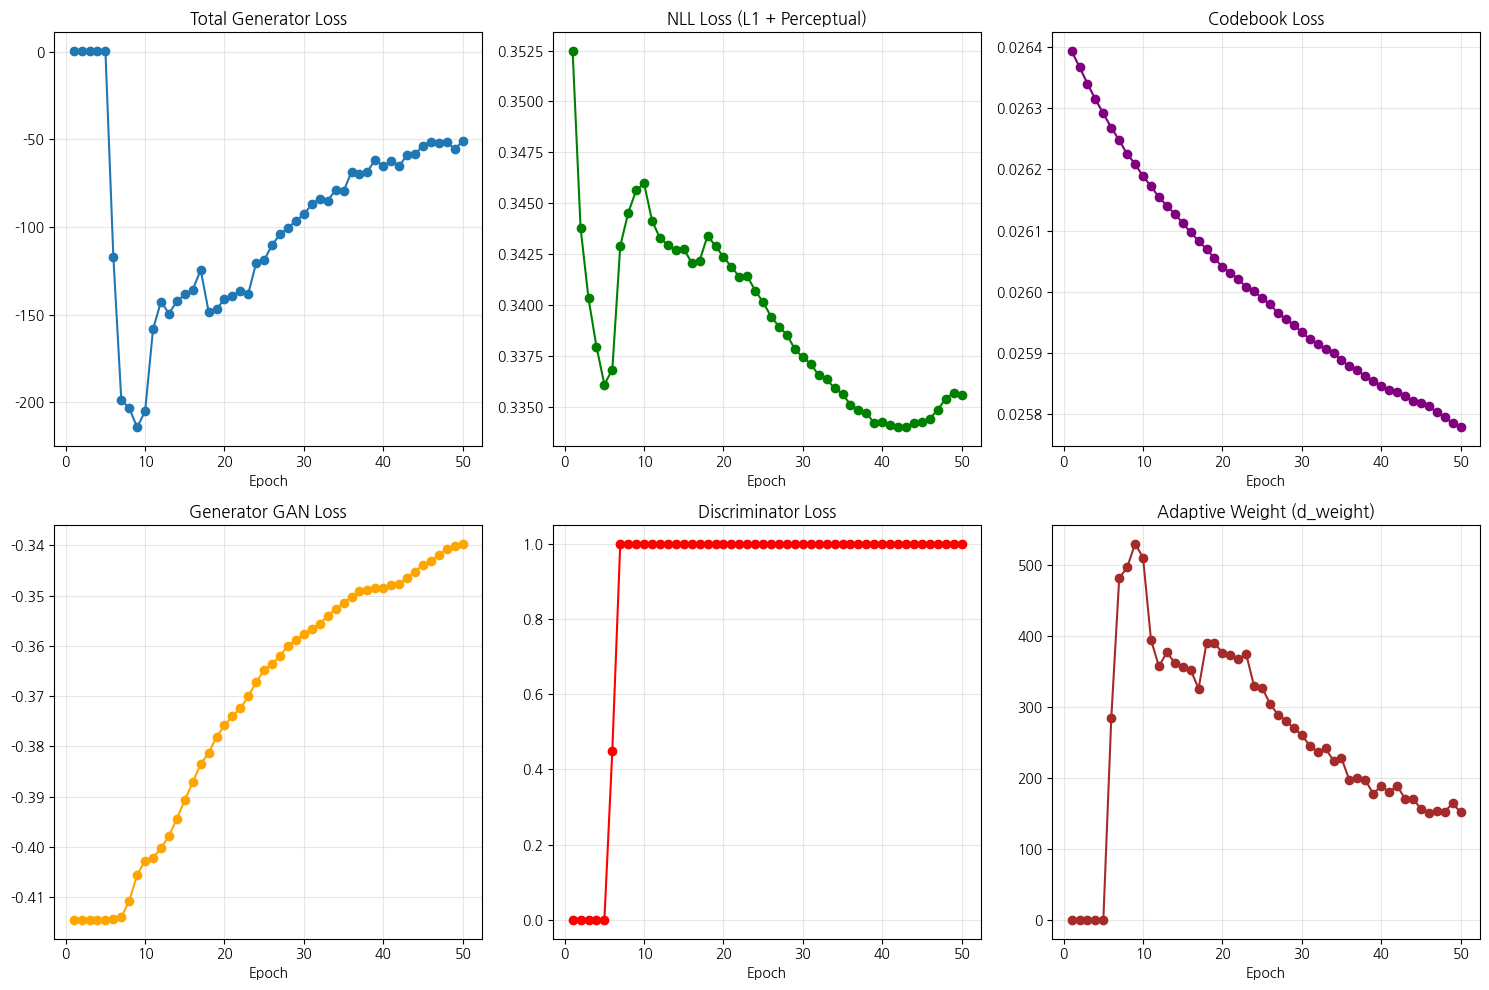

✅ 학습 곡선 저장됨: /content/drive/MyDrive/metal-defect/checkpoints/training_curves.png


In [ ]:
# =============================================================================
# 학습 곡선 시각화 (여러 Loss 항목)
# =============================================================================
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# train_logs는 딕셔너리 리스트이므로 각 항목 추출
epochs = range(1, len(train_logs) + 1)

# Total Loss
axes[0, 0].plot(epochs, [log['total_loss'] for log in train_logs], marker='o')
axes[0, 0].set_title('Total Generator Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].grid(True, alpha=0.3)

# NLL Loss (L1 + Perceptual)
axes[0, 1].plot(epochs, [log['nll_loss'] for log in train_logs], marker='o', color='green')
axes[0, 1].set_title('NLL Loss (L1 + Perceptual)')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].grid(True, alpha=0.3)

# Codebook Loss
axes[0, 2].plot(epochs, [log['codebook_loss'] for log in train_logs], marker='o', color='purple')
axes[0, 2].set_title('Codebook Loss')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].grid(True, alpha=0.3)

# G Loss
axes[1, 0].plot(epochs, [log['g_loss'] for log in train_logs], marker='o', color='orange')
axes[1, 0].set_title('Generator GAN Loss')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].grid(True, alpha=0.3)

# D Loss
axes[1, 1].plot(epochs, [log['d_loss'] for log in train_logs], marker='o', color='red')
axes[1, 1].set_title('Discriminator Loss')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].grid(True, alpha=0.3)

# Adaptive Weight
axes[1, 2].plot(epochs, [log['d_weight'] for log in train_logs], marker='o', color='brown')
axes[1, 2].set_title('Adaptive Weight (d_weight)')
axes[1, 2].set_xlabel('Epoch')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
save_path = f"{save_dir}/training_curves.png"
plt.savefig(save_path, dpi=150)
plt.show()
print(f"✅ 학습 곡선 저장됨: {save_path}")

In [ ]:
# =============================================================================
# Fine-tuning 전후 비교
# =============================================================================

# denormalize 함수
def denormalize(tensor):
    """[-1, 1] 범위를 [0, 1]로 변환"""
    img = tensor.cpu().detach()
    img = (img + 1) / 2
    img = img.clamp(0, 1)
    img = img.permute(1, 2, 0).numpy()
    return img

# Fine-tuned 모델을 평가 모드로
model.eval()

# 테스트 배치 가져오기
test_images, test_labels = next(iter(dataloader))
test_images = test_images.to(device)

# 재구성
with torch.no_grad():

    # Fine-tuned 모델
    rec_finetuned, _ = model(test_images)

# 시각화
n_samples = min(4, test_images.size(0))
fig, axes = plt.subplots(2, n_samples, figsize=(4*n_samples, 12))

for i in range(n_samples):
    axes[0, i].imshow(denormalize(test_images[i]))
    axes[0, i].set_title(f"원본 (class {test_labels[i].item()})")
    axes[0, i].axis('off')

    axes[1, i].imshow(denormalize(rec_finetuned[i]))
    axes[1, i].set_title("After (Fine-tuned)")
    axes[1, i].axis('off')

plt.tight_layout()
save_path = f"{save_dir}/comparison_before_after.png"
plt.savefig(save_path, dpi=150)
plt.show()
print(f"✅ 비교 이미지 저장됨: {save_path}")

In [ ]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import cv2

# 원본 모델 로드 (비교용)
model_original = VQModel(**config.model.params)
model_original.load_state_dict(
    {k: v for k, v in torch.load(ckpt_path, map_location="cuda", weights_only=False)["state_dict"].items()
     if not k.startswith("loss.")},
    strict=False
)
model_original = model_original.to(device)
model_original.eval()

with torch.no_grad():
    rec_orig, _ = model_original(test_images)
    rec_ft, _ = model(test_images)

    # 텐서 -> numpy (B, C, H, W) -> (B, H, W, C)
    orig_np = test_images.cpu().permute(0, 2, 3, 1).numpy()
    rec_orig_np = rec_orig.cpu().permute(0, 2, 3, 1).numpy()
    rec_ft_np = rec_ft.cpu().permute(0, 2, 3, 1).numpy()

    # 배치 평균 계산
    psnr_before, psnr_after = [], []
    ssim_before, ssim_after = [], []
    edge_before, edge_after = [], []

    for i in range(len(orig_np)):
        # 0-1 범위로 클리핑
        orig_img = np.clip(orig_np[i], 0, 1)
        rec_o = np.clip(rec_orig_np[i], 0, 1)
        rec_f = np.clip(rec_ft_np[i], 0, 1)

        # PSNR
        psnr_before.append(psnr(orig_img, rec_o, data_range=1.0))
        psnr_after.append(psnr(orig_img, rec_f, data_range=1.0))

        # SSIM (multichannel)
        ssim_before.append(ssim(orig_img, rec_o, data_range=1.0, channel_axis=2))
        ssim_after.append(ssim(orig_img, rec_f, data_range=1.0, channel_axis=2))

        # Edge preservation (grayscale로 변환 후 Canny)
        orig_gray = (orig_img.mean(axis=2) * 255).astype(np.uint8)
        rec_o_gray = (rec_o.mean(axis=2) * 255).astype(np.uint8)
        rec_f_gray = (rec_f.mean(axis=2) * 255).astype(np.uint8)

        edges_orig = cv2.Canny(orig_gray, 50, 150)
        edges_rec_o = cv2.Canny(rec_o_gray, 50, 150)
        edges_rec_f = cv2.Canny(rec_f_gray, 50, 150)

        # 엣지 IoU (intersection over union)
        iou_before = (edges_orig & edges_rec_o).sum() / ((edges_orig | edges_rec_o).sum() + 1e-6)
        iou_after = (edges_orig & edges_rec_f).sum() / ((edges_orig | edges_rec_f).sum() + 1e-6)
        edge_before.append(iou_before)
        edge_after.append(iou_after)

print(f"PSNR  - Before: {np.mean(psnr_before):.2f}dB, After: {np.mean(psnr_after):.2f}dB")
print(f"SSIM  - Before: {np.mean(ssim_before):.4f}, After: {np.mean(ssim_after):.4f}")
print(f"Edge IoU - Before: {np.mean(edge_before):.4f}, After: {np.mean(edge_after):.4f}")

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
PSNR  - Before: 26.18dB, After: 26.63dB
SSIM  - Before: 0.6396, After: 0.6452
Edge IoU - Before: 0.1713, After: 0.1682
